In [12]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [11]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT ='mask/new/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('', 'mask/label_map.pbtxt')

NUM_CLASSES = 5

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [38]:
PATH_TO_TEST_IMAGES_DIR = 'mask/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'fs.jpg') ]
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'ex{}.ojpg'.format(i)) for i in range(1, 5)  ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

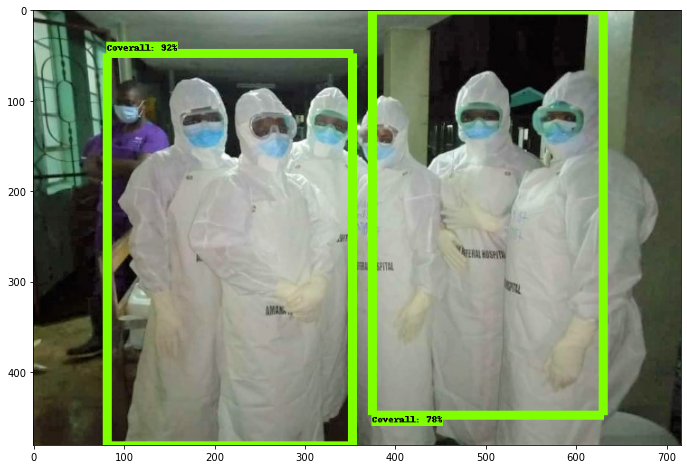

In [39]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      if image.format == "PNG":
        image = image.convert('RGB')
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=10)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

Could not open video device


In [ ]:
"""
Sections of this code were taken from:
https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
"""
import numpy as np

import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from utils import label_map_util

from utils import visualization_utils as vis_util

import cv2

# Path to frozen detection graph. This is the actual model that is used
# for the object detection.
PATH_TO_CKPT ='mask/new/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('', 'mask/label_map.pbtxt')
NUM_CLASSES = 5

sys.path.append("..")


def detect_in_video():

    # VideoWriter is the responsible of creating a copy of the video
    # used for the detections but with the detections overlays. Keep in
    # mind the frame size has to be the same as original video.
    out = cv2.VideoWriter('mask/test/video1.mp4', cv2.VideoWriter_fourcc(
        'M', 'J', 'P', 'G'), 10, (1280, 720))

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object
            # was detected.
            detection_boxes = detection_graph.get_tensor_by_name(
                'detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class
            # label.
            detection_scores = detection_graph.get_tensor_by_name(
                'detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name(
                'detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            cap = cv2.VideoCapture('mask/test/video.mp4')

            while(cap.isOpened()):
                # Read the frame
                ret, frame = cap.read()

                # Recolor the frame. By default, OpenCV uses BGR color space.
                # This short blog post explains this better:
                # https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/
                color_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                image_np_expanded = np.expand_dims(color_frame, axis=0)

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores,
                        detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})

                # Visualization of the results of a detection.
                # note: perform the detections using a higher threshold
                vis_util.visualize_boxes_and_labels_on_image_array(
                    color_frame,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=8,
                    min_score_thresh=.20)

                cv2.imshow('frame', color_frame)
                output_rgb = cv2.cvtColor(color_frame, cv2.COLOR_RGB2BGR)
                out.write(output_rgb)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            out.release()
            cap.release()
            cv2.destroyAllWindows()


def main():
    detect_in_video()


if __name__ == '__main__':
    main()